In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Reject participants.
reject = read_csv(os.path.join('data','reject.csv'))
data = data.merge(reject[['Subject','Reject']]).query('Reject==False')

## Define robot identities.
data.loc[np.logical_and(data.Valence=='Win',data.Action=='Go'),'Robot'] = 'GW'
data.loc[np.logical_and(data.Valence=='Win',data.Action=='No-Go'),'Robot'] = 'NGW'
data.loc[np.logical_and(data.Valence=='Lose',data.Action=='Go'),'Robot'] = 'GAL'
data.loc[np.logical_and(data.Valence=='Lose',data.Action=='No-Go'),'Robot'] = 'NGAL'

## Define exposure.
f = lambda x: np.arange(x.size)+1
data['Exposure'] = data.groupby(['Subject','Robot']).Trial.transform(f)
data = data.sort_values(['Version','Subject','Robot','Exposure']).reset_index(drop=True)

## Section 2: Plot Accuracy by Exposure

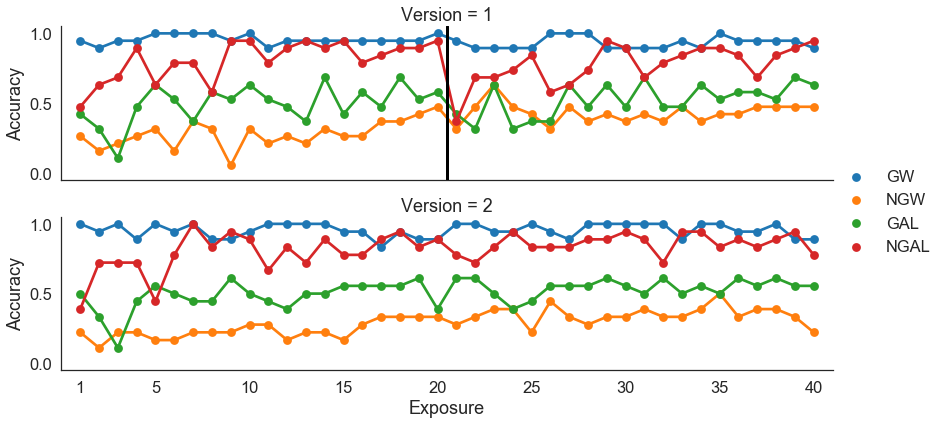

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
g = sns.FacetGrid(data, row='Version', height=3, aspect=4)
xticks = np.array([0,4,9,14,19,24,29,34,39])
palette = sns.color_palette(n_colors=4)

## Plot accuracy.
g.map(sns.pointplot, 'Exposure', 'Accuracy', 'Robot', order=np.arange(40)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)
g.set(xticks=xticks, xticklabels=xticks+1, xlim=(-1,40), ylim=(-0.05,1.05))
g.axes[0,0].axvline(19.5,color='k',lw=3,zorder=10);
g.add_legend()

sns.despine()

## Section 3: Plot Accuracy by Participant

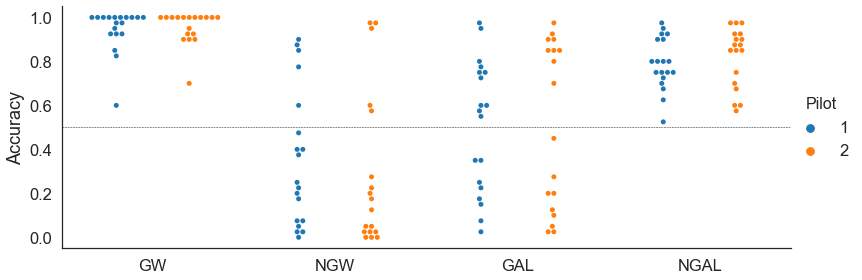

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute accuracy per version/subject/robot.
gb = data.groupby(['Version','Subject','Robot']).Accuracy.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = sns.color_palette(n_colors=4)

## Plot accuracy.
sns.swarmplot('Robot', 'Accuracy', 'Version', data=gb, order=['GW','NGW','GAL','NGAL'], dodge=True)
ax.axhline(0.50, color='0.1', lw=0.5, linestyle='--')
legend = ax.legend(loc=7, bbox_to_anchor=(1.1,0.5), frameon=False, title='Pilot')
plt.setp(legend.get_title(),fontsize=16)
ax.set(xlabel='', ylim=(-0.05,1.05))

sns.despine()
plt.tight_layout()

## Section 4: Sensitivity to Sham Feedback

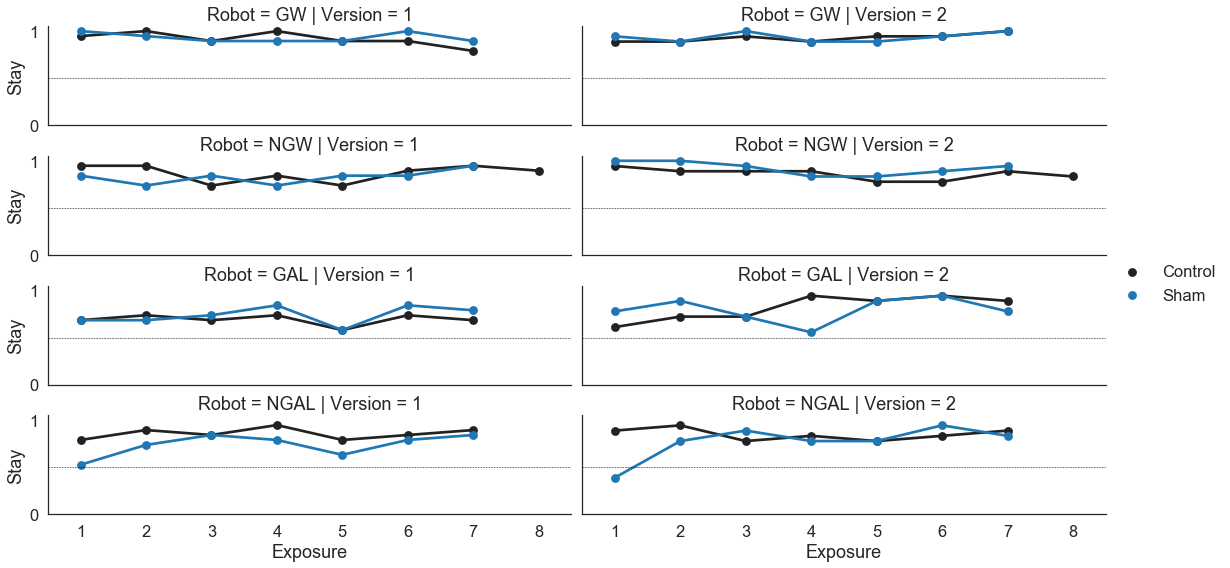

In [5]:
from pandas import concat

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous sham.
data['PrevSham'] = data.groupby(['Subject','Robot']).Sham.transform(lambda x: np.roll(x,1))

## Define stay trials.
f = lambda arr: (arr == np.roll(arr, 1)).astype(int)
data['Stay'] = data.groupby(['Subject','Robot']).Choice.transform(f)

## Compute p(Stay) by sham/control trials.
gb = data.query('Sham==1 or PrevSham==1').query('Exposure > 1 and Exposure < 40')
gb = gb.groupby(['Version','Robot','Sham','PrevSham','Exposure']).Stay.mean().reset_index()

## Update labels.
f = lambda x: np.arange(x.size)
gb['Condition'] = np.where(gb.Sham, 'Control', 'Sham')
gb['Exposure'] = gb.groupby(['Version','Robot','Condition']).Exposure.transform(f)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
g = sns.FacetGrid(gb, row='Robot', col='Version', row_order=['GW','NGW','GAL','NGAL'], aspect=4, height=2)

## Plot stay probabilities.
g.map(sns.pointplot, 'Exposure', 'Stay', 'Condition', order=np.arange(8), hue_order=['Control','Sham'])
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', linestyle='--', lw=0.5)
    
## Add detials.
g.set(xlim=(-0.5,7.5), xticks=np.arange(8), xticklabels=np.arange(8)+1, ylim=(0,1.05))
g.add_legend();